In [1]:
import os
import cytopath
import scvelo as scv

import numpy as np
np.random.seed(42)
random_state=42
import pandas as pd

from scipy import sparse

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Set plotting parameters for scvelo
scv.set_figure_params(style='scvelo', dpi=50, dpi_save=300, frameon=None, vector_friendly=True, 
                                  transparent=True, fontsize=12, figsize=None, color_map=None, facecolor=None, 
                                  format='svg', ipython_format='png2x')

In [3]:
# Import raw data
adata = scv.read('../cd8_development/raw_dario_chronic.h5ad')

In [4]:
# Preprocess data
scv.pp.filter_and_normalize(adata, n_top_genes=3000, min_shared_counts=10, flavor='seurat', log=True)
scv.pp.moments(adata)
scv.tl.umap(adata, random_state=random_state)

Filtered out 19989 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 3000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:13) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
# Estimate velocity
scv.tl.velocity(adata, mode='deterministic')

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [6]:
# Estimate transition probability matrix
scv.tl.velocity_graph(adata, mode_neighbors='connectivities') 
scv.tl.terminal_states(adata, random_state=random_state)

adata.uns["T_forward"] = scv.utils.get_transition_matrix(adata, self_transitions=False)

computing velocity graph
    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


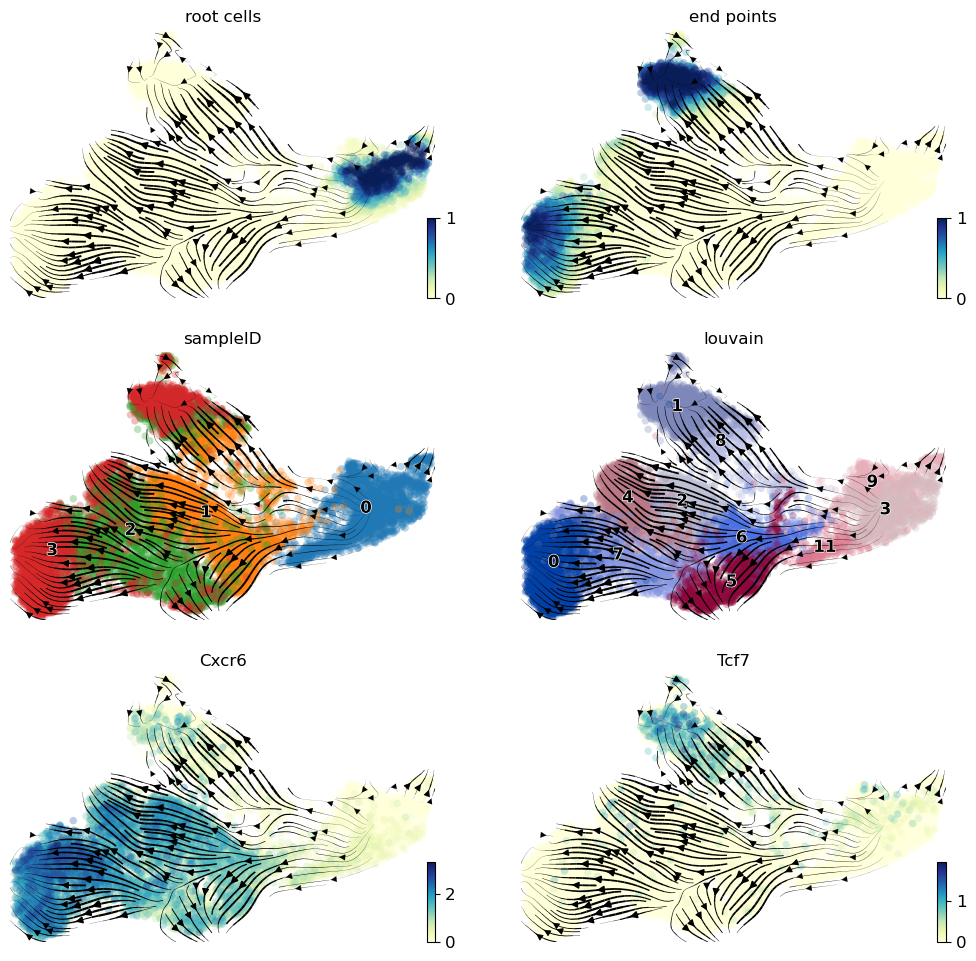

In [7]:
# Visualise terminal states
scv.tl.velocity_embedding(adata)
scv.pl.velocity_embedding_stream(adata, color=['root_cells', 'end_points',
                                               'sampleID', 'louvain',
                                               'Cxcr6', 'Tcf7'],
                                             ncols=2, color_map='YlGnBu')

In [8]:
# Run cytopath
if sparse.issparse(adata.X):
    adata.X = adata.X.toarray()

cytopath.sampling(adata, num_cores=os.cpu_count()-1)

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 2069
Number of initial simulations (sim_number) set to 4138
Number of initial simulation steps (max_steps) set to 21

Sampling round: 0


  0%|          | 0/282 [00:00<?, ?it/s]

93.81 % of required simulations obtained for lagging end point 0.
5.842 % of simulations reached atleast one endpoint. Increasing number of simulation steps to 42.

Sampling round: 1


  0%|          | 0/282 [00:00<?, ?it/s]

Sampling done.


In [9]:
# Infer trajectories
cytopath.trajectories(adata, num_cores=os.cpu_count()-1)

Stage 1 clustering done. Aligning clusters for end point 0
Calculating hausdorff distances


  0%|          | 0/2069 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/129 [00:00<?, ?it/s]

Final clustering done. Aligning clusters for end point 0


  0%|          | 0/129 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/1 [00:00<?, ?it/s]

Stage 1 clustering done. Aligning clusters for end point 1
Calculating hausdorff distances


  0%|          | 0/2069 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/1372 [00:00<?, ?it/s]

Final clustering done. Aligning clusters for end point 1


  0%|          | 0/1372 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/1 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point 0 at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  0


  0%|          | 0/891 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  0 (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point 1 at each step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  1


  0%|          | 0/981 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  1 (i.e. cells neighborhood)


  0%|          | 0/1 [00:00<?, ?it/s]

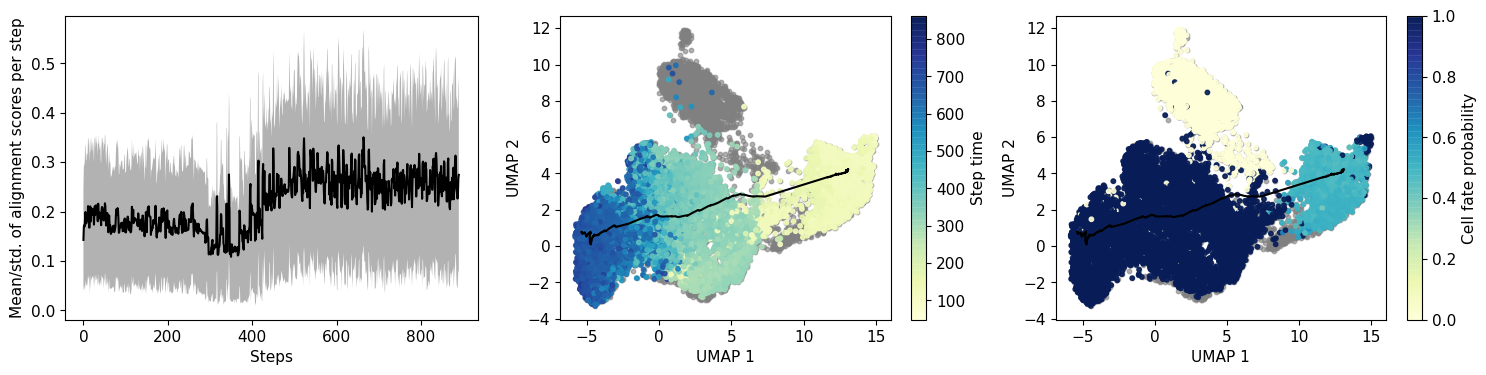

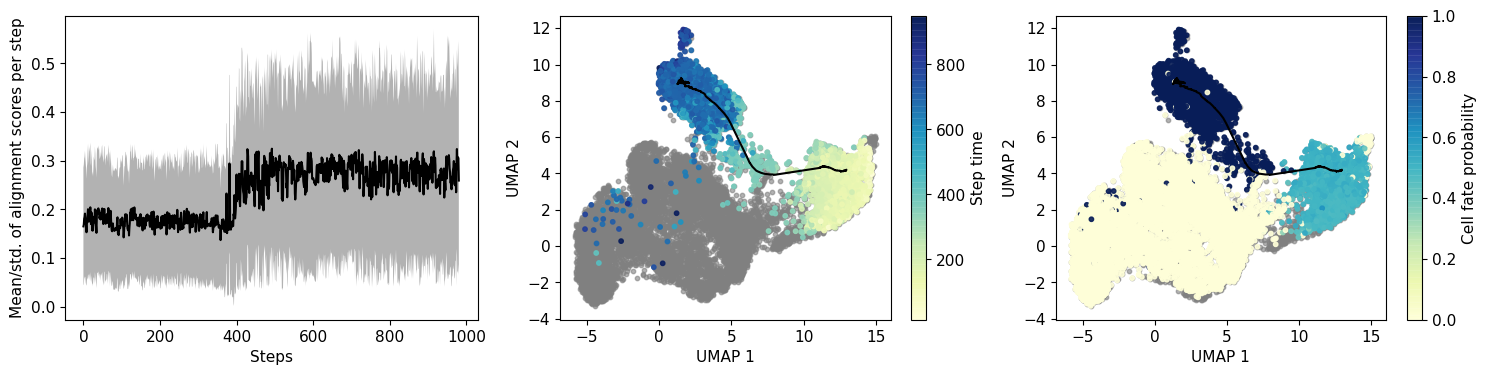

In [10]:
# Plot allignment and trajectories
cytopath.plot_trajectories(adata, directory='', basis='umap', smoothing=False, size=10, figsize=(18,4))

(-6.870107126235962,
 16.019426774978637,
 -4.056339287757874,
 12.686755681037903)

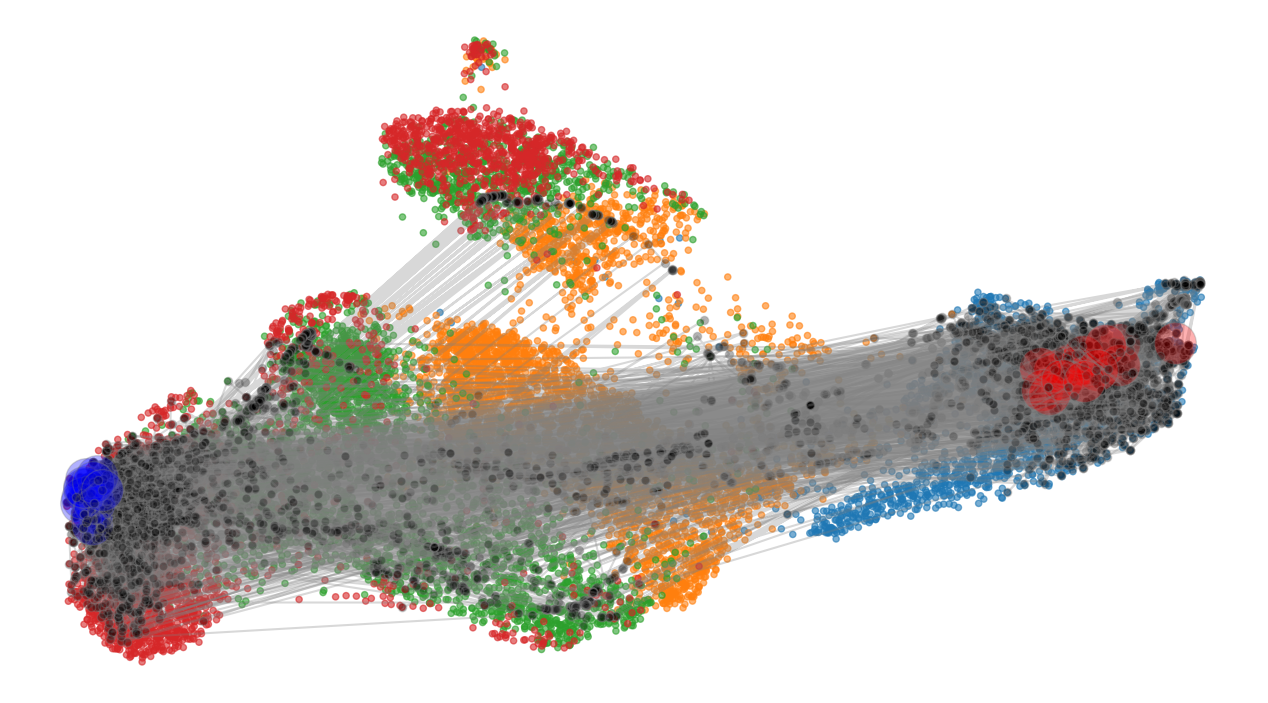

In [11]:
# Exhausted subtrajectory
# Raw simulations are first clustered
# Each group of simulations is used to generate a subtrajectory that are shown here
# One interpretation of subtrajectories is that they are alternatives to the final inferred trajectory
# The final trajectory is then essentially an ensemble of these "alternative" paths

subtraj_data = pd.DataFrame(adata.uns['subtrajectories']['subtrajectory_coordinates']['0'])
plt.figure(figsize=(16,9))
plt.scatter(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1],c = adata.obs.sampleID.astype(int),
                            s = 20, cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", adata.uns['sampleID_colors']), 
                            alpha=0.6)
for subtraj in subtraj_data['Subtrajectory'].unique():
    temp = subtraj_data.loc[subtraj_data['Subtrajectory'] == subtraj].sort_values('Step')
    plt.plot(temp.values[0,0], temp.values[0,1], '-o', color='grey', alpha=0.3, ms=30, markerfacecolor='red')
    plt.plot(temp.values[1:,0], temp.values[1:,1], '-o', color='grey', alpha=0.3, markerfacecolor='black')
    plt.plot(temp.values[-1,0], temp.values[-1,1], '-o', color='grey', alpha=0.3,ms=30, markerfacecolor='blue')
plt.axis('off')

(-6.870107126235962,
 16.019426774978637,
 -4.056339287757874,
 12.686755681037903)

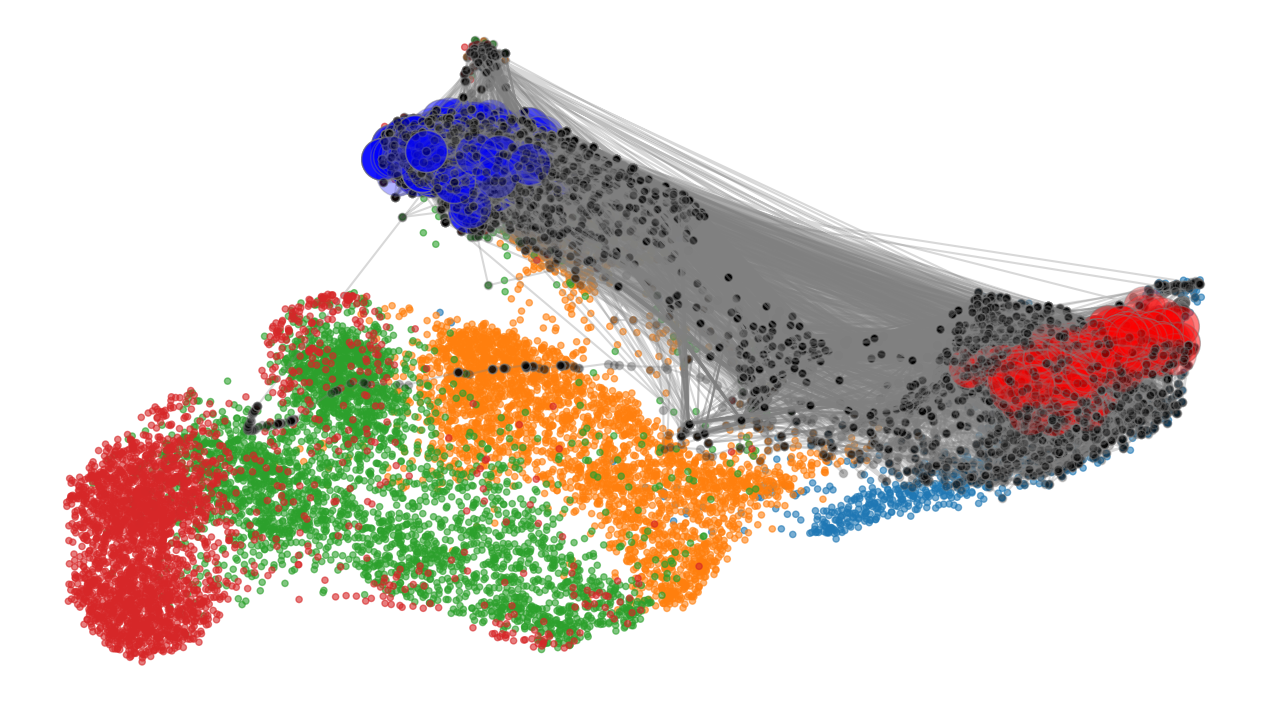

In [12]:
# Memory subtrajectory
subtraj_data = pd.DataFrame(adata.uns['subtrajectories']['subtrajectory_coordinates']['1'])
plt.figure(figsize=(16,9))
plt.scatter(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1],c = adata.obs.sampleID.astype(int),
                            s = 20, cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", adata.uns['sampleID_colors']), 
                            alpha=0.6)
for subtraj in subtraj_data['Subtrajectory'].unique():
    temp = subtraj_data.loc[subtraj_data['Subtrajectory'] == subtraj].sort_values('Step')
    plt.plot(temp.values[0,0], temp.values[0,1], '-o', color='grey', alpha=0.3, ms=30, markerfacecolor='red')
    plt.plot(temp.values[1:,0], temp.values[1:,1], '-o', color='grey', alpha=0.3, markerfacecolor='black')
    plt.plot(temp.values[-1,0], temp.values[-1,1], '-o', color='grey', alpha=0.3,ms=30, markerfacecolor='blue')
plt.axis('off')